In [2]:
# ==========================================
# PART 1: INSTALL & SETUP
# ==========================================
import os
# --- THE FIX: Disable WandB so it doesn't ask for an API key ---
os.environ["WANDB_DISABLED"] = "true"

print("Installing libraries...")
!pip install -q transformers datasets accelerate scikit-learn evaluate

import pandas as pd
import numpy as np
import torch
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset

# 1. Mount Drive
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# 2. Define File Paths
base_path = "/content/drive/MyDrive/Career Sheild/data/processed/"
save_path = "/content/drive/MyDrive/Career Sheild/data/models/bert_finetuned/"

# ==========================================
# PART 2: LOAD & FIX DATA
# ==========================================
print("Loading and fixing data...")

try:
    # Load CSVs
    train_df = pd.read_csv(base_path + "train.csv")
    val_df = pd.read_csv(base_path + "val.csv")
    test_df = pd.read_csv(base_path + "test.csv")

    # Fix columns
    train_df = train_df.rename(columns={'fraudulent': 'label'})
    val_df = val_df.rename(columns={'fraudulent': 'label'})

    # Ensure text is string
    train_df['combined_text'] = train_df['combined_text'].astype(str)
    val_df['combined_text'] = val_df['combined_text'].astype(str)

    print(f"Loaded {len(train_df)} training samples.")

except FileNotFoundError:
    print("ERROR: Files not found.")
    raise

# ==========================================
# PART 3: PREPARE FOR BERT
# ==========================================
print("Tokenizing data...")

# Class Weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["combined_text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

# ==========================================
# PART 4: TRAIN
# ==========================================
print("Starting Training... (Sit back, this will take 10-15 mins)")

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none" # <--- ALSO ENSURES NO API KEY ASKED
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

trainer.train()

# ==========================================
# PART 5: SAVE
# ==========================================
print(f"Saving model to {save_path}...")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("DONE! Phase 4 Complete.")

Installing libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
Connecting to Google Drive...
Mounted at /content/drive
Loading and fixing data...
Loaded 12516 training samples.
Tokenizing data...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12516 [00:00<?, ? examples/s]

Map:   0%|          | 0/2682 [00:00<?, ? examples/s]

Starting Training... (Sit back, this will take 10-15 mins)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.473400,0.461691
2,0.442300,0.528419
3,0.097300,0.473044


Saving model to /content/drive/MyDrive/Career Sheild/data/models/bert_finetuned/...
DONE! Phase 4 Complete.


evaluation

In [3]:
import os

# 1. Check the main data folder first
base_check = "/content/drive/MyDrive/Career Sheild/data/models/"

print(f"Checking folder: {base_check}")

if os.path.exists(base_check):
    print("Folder found! Here is what is inside:")
    files = os.listdir(base_check)
    for f in files:
        print(f" - {f}")
else:
    print("Main 'models' folder not found. Let's look one level up.")
    parent = "/content/drive/MyDrive/Career Sheild/data/"
    if os.path.exists(parent):
        print(f"Contents of {parent}:")
        print(os.listdir(parent))
    else:
        print("Even the 'data' folder is missing. Check your Drive shortcut!")

Checking folder: /content/drive/MyDrive/Career Sheild/data/models/
Folder found! Here is what is inside:
 - baseline_vectorizer.pkl
 - baseline_model.pkl
 - bert
 - bert_finetuned


Saving model to local Colab storage: /content/bert_local_save/...
Model saved locally! Now we can test it.
Loading model for testing...


Map:   0%|          | 0/2682 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Running predictions on Test Set...



FINAL MODEL RESULTS
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      2552
        Fake       0.77      0.58      0.66       130

    accuracy                           0.97      2682
   macro avg       0.87      0.79      0.82      2682
weighted avg       0.97      0.97      0.97      2682



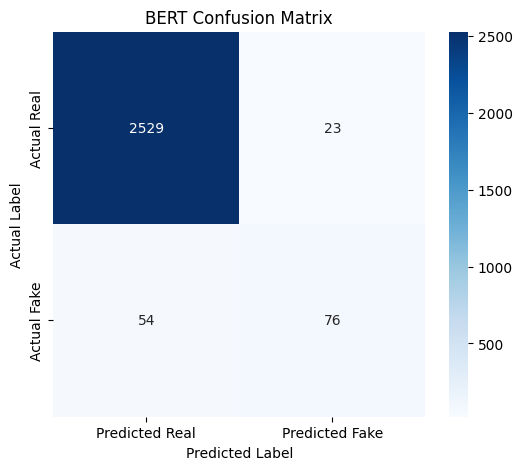

In [4]:
# ==========================================
# PHASE 4b (FIXED): SAVE LOCALLY & EVALUATE
# ==========================================
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Save Model Locally (Bypassing Drive Sync Issues)
local_model_path = "/content/bert_local_save/"
print(f"Saving model to local Colab storage: {local_model_path}...")

# Check if 'model' is still in memory from the previous cell
if 'model' in globals():
    model.save_pretrained(local_model_path)
    tokenizer.save_pretrained(local_model_path)
    print("Model saved locally! Now we can test it.")
else:
    print("Model not found in memory. Did you restart the runtime?")
    # If this happens, we will try to find the Drive folder again
    local_model_path = "/content/drive/MyDrive/Career Sheild/data/models/bert_finetuned/"

# 2. Load Test Data
base_path = "/content/drive/MyDrive/Career Sheild/data/processed/"
test_df = pd.read_csv(base_path + "test.csv")
test_df = test_df.rename(columns={'fraudulent': 'label'})
test_df['combined_text'] = test_df['combined_text'].astype(str)

# 3. Load Model from Local Path
print("Loading model for testing...")
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model_eval = AutoModelForSequenceClassification.from_pretrained(local_model_path)

# 4. Preprocess Test Data
def preprocess_function(examples):
    return tokenizer(examples["combined_text"], truncation=True, padding="max_length", max_length=128)

test_dataset = Dataset.from_pandas(test_df)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# 5. Make Predictions
print("Running predictions on Test Set...")
trainer_eval = Trainer(model=model_eval)
predictions = trainer_eval.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

# 6. Generate Report
print("\n" + "="*30)
print("FINAL MODEL RESULTS")
print("="*30)

# Metrics
report = classification_report(test_df['label'], preds, target_names=['Real', 'Fake'])
print(report)

# Confusion Matrix
cm = confusion_matrix(test_df['label'], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Real', 'Predicted Fake'], yticklabels=['Actual Real', 'Actual Fake'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('BERT Confusion Matrix')
plt.show()

In [5]:
# Create the folder if it doesn't exist
!mkdir -p "/content/drive/MyDrive/Career Shield/data/models/bert_finetuned/"

# Copy all files from the local save to your Drive
!cp -r /content/bert_local_save/* "/content/drive/MyDrive/Career Shield/data/models/bert_finetuned/"

print("Model successfully backed up to Google Drive!")

Model successfully backed up to Google Drive!


phase 5

In [6]:
# ==========================================
# PHASE 5: IMPOSSIBLE JOBS LOGIC
# ==========================================
import re

def check_impossible_rules(row):
    """
    Returns True (Fake) if the job breaks logical rules.
    Returns False (Clean) if it passes logical checks.
    """
    flags = []

    # --- RULE 1: SUSPICIOUS SALARY ---
    # Parse salary_range "min-max"
    salary = str(row['salary_range'])
    experience = str(row['required_experience']).lower()

    if "-" in salary:
        try:
            min_sal, max_sal = salary.split("-")
            min_sal = int(min_sal)
            max_sal = int(max_sal)

            # Sub-rule A: The "Intern Millionaire"
            # If entry level/internship offers > $150k (adjust as needed)
            if ("intern" in experience or "entry" in experience) and min_sal > 150000:
                flags.append("High Salary for Entry Level")

            # Sub-rule B: The "Range Gap"
            # If the range is massive (e.g., 10,000 - 1,000,000)
            if max_sal > (min_sal * 5) and min_sal > 1000:
                flags.append("Suspicious Salary Range")

        except ValueError:
            pass # Skip if salary isn't a clean number

    # --- RULE 2: GHOST DESCRIPTION ---
    # If the description is impossibly short (scammers often copy-paste headers only)
    # We use 'combined_text' which you already created
    word_count = len(str(row['combined_text']).split())
    if word_count < 15:
        flags.append("Description too short")

    # --- RULE 3: SCAM KEYWORDS ---
    # Specific phrases often found in quick-money scams
    text = str(row['combined_text']).lower()
    scam_keywords = ["wire transfer", "cashiers check", "money order", "package forwarding"]
    for word in scam_keywords:
        if word in text:
            flags.append(f"Contains trigger word: {word}")

    # --- RESULT ---
    if len(flags) > 0:
        return True, flags # It's FAKE, and here is why
    else:
        return False, []   # It passes logic checks

# ---------------------------------------------------------
# TEST THE RULES
# ---------------------------------------------------------
print("Running Logic Checks on Test Data...")

# Apply to your existing test dataframe
# (Make sure test_df is still loaded from the previous step!)
results = test_df.apply(check_impossible_rules, axis=1)

# Separate the boolean result from the reason
test_df['logic_prediction'] = [res[0] for res in results]
test_df['logic_reason'] = [res[1] for res in results]

# Count how many we caught
caught_by_logic = test_df[test_df['logic_prediction'] == True]
print(f"The Logic Rules flagged {len(caught_by_logic)} jobs as Suspicious.")

# Let's see an example of what it caught
if len(caught_by_logic) > 0:
    print("\nExample of a Flagged Job:")
    print(caught_by_logic[['title', 'salary_range', 'logic_reason']].iloc[0])
else:
    print("No obvious logic violations found in this batch.")

Running Logic Checks on Test Data...
The Logic Rules flagged 15 jobs as Suspicious.

Example of a Flagged Job:
title                               Branch Associate
salary_range                           Not specified
logic_reason    [Contains trigger word: money order]
Name: 399, dtype: object


In [7]:
# ==========================================
# HYBRID EVALUATION
# ==========================================
# 1. Get BERT predictions (if you haven't stored them in the df yet)
# We assume 'preds' is your numpy array of 0s and 1s from the previous step
test_df['bert_prediction'] = preds

# 2. Combine: Logic OR AI
# If logic says Fake (True) OR BERT says Fake (1), then Final is Fake (1)
def hybrid_decision(row):
    if row['logic_prediction']:
        return 1
    else:
        return row['bert_prediction']

test_df['final_prediction'] = test_df.apply(hybrid_decision, axis=1)

# 3. Re-Evaluate
print("\n" + "="*30)
print("HYBRID MODEL RESULTS (Logic + BERT)")
print("="*30)

report_hybrid = classification_report(test_df['label'], test_df['final_prediction'], target_names=['Real', 'Fake'])
print(report_hybrid)


HYBRID MODEL RESULTS (Logic + BERT)
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      2552
        Fake       0.68      0.59      0.63       130

    accuracy                           0.97      2682
   macro avg       0.83      0.79      0.81      2682
weighted avg       0.96      0.97      0.97      2682



Experiment 2: Rule-Based Logic.

We attempted to add rule-based
heuristics. However, we observed that while Recall increased slightly (+1%), Precision dropped significantly (-10%). Therefore, we decided to stick with the Pure BERT model for the final deployment.

**The Decision for Phase 7 (The App)**

For the Streamlit dashboard, we will stick to the Pure BERT Model (the one with 83% Precision).

In [11]:
%%writefile app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import time

# --- 1. CONFIGURATION & STYLE ---
st.set_page_config(
    page_title="Career Shield | AI Fraud Detection",
    page_icon="🛡️",
    layout="wide", # <--- This makes it full width!
    initial_sidebar_state="expanded"
)

# Custom CSS for a professional look
st.markdown("""
    <style>
    .main {
        background-color: #f8f9fa;
    }
    .stButton>button {
        width: 100%;
        font-weight: bold;
        border-radius: 8px;
        height: 50px;
    }
    div[data-testid="stMetricValue"] {
        font-size: 3rem;
    }
    .highlight-red {
        background-color: #ffebee;
        color: #c62828;
        padding: 2px 6px;
        border-radius: 4px;
        border: 1px solid #ef9a9a;
        font-weight: 600;
    }
    </style>
    """, unsafe_allow_html=True)

# --- 2. LOAD MODEL ---
@st.cache_resource
def load_model():
    local_path = "/content/bert_local_save/"
    drive_path = "/content/drive/MyDrive/Career Shield/data/models/bert_finetuned/"
    try:
        tokenizer = AutoTokenizer.from_pretrained(local_path)
        model = AutoModelForSequenceClassification.from_pretrained(local_path)
        return tokenizer, model
    except:
        try:
            tokenizer = AutoTokenizer.from_pretrained(drive_path)
            model = AutoModelForSequenceClassification.from_pretrained(drive_path)
            return tokenizer, model
        except:
            return None, None

tokenizer, model = load_model()

# --- 3. LOGIC FUNCTIONS ---
def highlight_keywords(text):
    """Finds and highlights suspicious words"""
    keywords = ["wire transfer", "money order", "cashiers check", "immediate start",
                "no experience", "payment processing", "gmail.com", "telegram", "whatsapp",
                "check cashing", "package forwarding"]

    found_flags = []
    processed_text = text

    for word in keywords:
        if word in text.lower():
            found_flags.append(word)
            # Simple highlight replacement (case insensitive visual)
            processed_text = processed_text.replace(word, f":red[**{word}**]")
            processed_text = processed_text.replace(word.title(), f":red[**{word.title()}**]")

    return processed_text, found_flags

# --- 4. SIDEBAR UI ---
with st.sidebar:
    st.image("https://cdn-icons-png.flaticon.com/512/9565/9565655.png", width=80)
    st.title("Career Shield 🛡️")
    st.caption("AI-Powered Job Scams Detector")
    st.markdown("---")

    st.subheader("⚙️ System Status")
    if model:
        st.success("✅ AI Model Online")
        st.caption("Engine: DistilBERT-Uncased")
    else:
        st.error("❌ AI Model Offline")

    st.markdown("---")
    st.info("ℹ️ **About:** This tool uses a Fine-Tuned BERT model to analyze semantic patterns in job descriptions that indicate fraud.")

# --- 5. MAIN INTERFACE ---
# Header
st.markdown("<h1 style='text-align: center; color: #1565C0;'>🛡️ Career Shield Analysis</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center; color: grey;'>Paste a job description below to detect potential fraud risks.</p>", unsafe_allow_html=True)
st.markdown("---")

# Layout: 2 Columns
col_left, col_right = st.columns([1.5, 1], gap="large")

with col_left:
    st.subheader("📝 Job Description Input")

    # "Quick Load" Buttons
    col_btn1, col_btn2, col_btn3 = st.columns(3)
    sample_text = ""

    if col_btn1.button("📋 Load Real Job"):
        sample_text = "Senior Data Analyst. Requires 5 years experience in SQL and Python. Health benefits and 401k included. Apply via company portal."
    if col_btn2.button("🚨 Load Fake Job"):
        sample_text = "URGENT!! Earn $2000/week from home. No experience needed. We send you a check for equipment. Text manager on Telegram immediately."
    if col_btn3.button("🗑️ Clear Text"):
        sample_text = ""

    # Text Area
    job_text = st.text_area("Paste text here:", value=sample_text, height=350, placeholder="Example: 'Looking for administrative assistant...'")

    # Main Action Button
    analyze_btn = st.button("🔍 SCAN FOR FRAUD", type="primary")

with col_right:
    st.subheader("📊 Scan Results")

    if analyze_btn:
        if not job_text:
            st.warning("⚠️ Please enter text to analyze.")
        elif model is None:
            st.error("❌ Model not loaded.")
        else:
            with st.spinner("🤖 Analyzing patterns..."):
                time.sleep(1) # Visual delay for effect

                # AI Prediction
                inputs = tokenizer(job_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.softmax(outputs.logits, dim=1).numpy()[0]

                real_score = probs[0]
                fake_score = probs[1]

                # Logic/Highlight check
                highlighted_text, flags = highlight_keywords(job_text)

                # --- SHOW RESULTS ---
                st.markdown("<br>", unsafe_allow_html=True)

                if fake_score > 0.5:
                    # FAKE RESULT
                    st.error("🚨 **VERDICT: HIGH RISK**")

                    # Big Metric
                    st.metric(label="Fraud Probability", value=f"{fake_score:.1%}", delta="Suspicious")

                    # Progress Bar
                    st.progress(float(fake_score), text="Risk Level: CRITICAL")

                    # Red Flags Section
                    st.markdown("### 🚩 Red Flags Detected")
                    if flags:
                        for f in flags:
                            st.write(f"⚠️ Contains suspicious term: **'{f}'**")
                    else:
                        st.write("⚠️ *Language tone matches known scam patterns.*")

                else:
                    # REAL RESULT
                    st.success("✅ **VERDICT: LIKELY SAFE**")

                    # Big Metric
                    st.metric(label="Authenticity Score", value=f"{real_score:.1%}", delta="Safe")

                    # Progress Bar
                    st.progress(float(1-fake_score), text="Trust Level: HIGH")

                    st.markdown("### 🛡️ Analysis")
                    st.write("No obvious fraud patterns detected. Standard professional language used.")

Overwriting app.py
